# Neural Network Pruning: Structured vs Unstructured

## Overview
This notebook explores neural network pruning techniques, a crucial model compression method that removes unnecessary weights or neurons from trained models. We'll cover both structured and unstructured pruning approaches, implement magnitude-based pruning, and visualize sparsity patterns.

## Table of Contents
1. [Introduction to Pruning](#introduction)
2. [Types of Pruning](#types)
3. [Pruning Strategies](#strategies)
4. [Implementation Setup](#setup)
5. [Unstructured Magnitude Pruning](#unstructured)
6. [Structured Pruning](#structured)
7. [Iterative vs One-Shot Pruning](#iterative)
8. [Sparsity Pattern Visualization](#visualization)
9. [Performance Analysis](#analysis)
10. [Conclusions](#conclusions)

## 1. Introduction to Pruning {#introduction}

### What is Neural Network Pruning?
Neural network pruning is a model compression technique that removes redundant or less important parameters from a trained neural network. The goal is to reduce model size and computational requirements while maintaining acceptable performance.

### Key Benefits:
- **Reduced Memory Footprint**: Fewer parameters mean less storage requirements
- **Faster Inference**: Fewer computations lead to quicker predictions
- **Energy Efficiency**: Lower computational overhead reduces power consumption
- **Deployment Flexibility**: Smaller models can run on resource-constrained devices

### Trade-offs:
- **Model Capacity vs Speed**: Removing parameters reduces the model's learning capacity
- **Accuracy vs Efficiency**: Aggressive pruning may hurt model performance
- **Training vs Inference Time**: Some pruning methods require retraining

## 2. Types of Pruning {#types}

### Unstructured Pruning
- **Definition**: Removes individual weights based on certain criteria (e.g., magnitude)
- **Characteristics**: 
  - Creates irregular sparsity patterns
  - Higher compression ratios possible
  - Requires specialized hardware/software for speedup
  - Fine-grained control over pruning

### Structured Pruning
- **Definition**: Removes entire structures like neurons, channels, or layers
- **Characteristics**:
  - Creates regular sparsity patterns
  - Immediate speedup on standard hardware
  - Lower compression ratios
  - Coarse-grained pruning decisions

### Comparison Table:

| Aspect | Unstructured | Structured |
|--------|-------------|------------|
| Granularity | Individual weights | Entire structures |
| Hardware Support | Specialized | Standard |
| Compression Ratio | Higher | Lower |
| Implementation | Complex | Simple |
| Immediate Speedup | No | Yes |

## 3. Pruning Strategies {#strategies}

### Magnitude-based Pruning
- Remove weights with smallest absolute values
- Simple and effective baseline method
- Assumption: smaller weights contribute less to the output

### Gradient-based Pruning
- Consider both weight magnitude and gradient information
- Remove weights with small gradients (less sensitive to changes)

### Lottery Ticket Hypothesis
- Find sparse subnetworks that can be trained to match full network performance
- Iterative magnitude pruning with weight rewinding

### Iterative vs One-Shot Approaches
- **Iterative**: Gradually prune and retrain multiple times
- **One-Shot**: Prune large portions of the network at once
- **Trade-off**: Iterative is slower but typically preserves accuracy better

## 4. Implementation Setup {#setup}

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import time
from collections import OrderedDict

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Define a simple CNN for demonstration
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Calculate the size after convolutions and pooling
        # 28x28 -> 14x14 -> 7x7 -> 3x3 (with padding)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = self.dropout1(x)
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|█████████████████████████████████████████████████████████| 9.91M/9.91M [00:17<00:00, 555kB/s]
100%|████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 65.5kB/s]
100%|█████████████████████████████████████████████████████████| 1.65M/1.65M [00:06<00:00, 245kB/s]
100%|████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]

Training samples: 60000
Test samples: 10000


In [3]:
# Training function
def train_model(model, train_loader, num_epochs=5, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, '
                      f'Loss: {running_loss/(batch_idx+1):.4f}, '
                      f'Acc: {100.*correct/total:.2f}%')
    
    return model

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    start_time = time.time()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    inference_time = time.time() - start_time
    accuracy = 100. * correct / total
    
    return accuracy, inference_time

In [4]:
# Train the original model
print("Training original model...")
original_model = SimpleCNN()
original_model = train_model(original_model, train_loader, num_epochs=3)

# Evaluate original model
original_accuracy, original_time = evaluate_model(original_model, test_loader)
print(f"\nOriginal Model - Accuracy: {original_accuracy:.2f}%, Inference Time: {original_time:.4f}s")

# Calculate original model size
original_params = sum(p.numel() for p in original_model.parameters())
print(f"Original Model Parameters: {original_params:,}")

Training original model...
Epoch 1/3, Batch 0, Loss: 2.3103, Acc: 6.25%
Epoch 1/3, Batch 100, Loss: 0.8198, Acc: 72.46%
Epoch 1/3, Batch 200, Loss: 0.5033, Acc: 83.51%
Epoch 1/3, Batch 300, Loss: 0.3826, Acc: 87.62%
Epoch 1/3, Batch 400, Loss: 0.3138, Acc: 89.91%
Epoch 2/3, Batch 0, Loss: 0.0772, Acc: 97.66%
Epoch 2/3, Batch 100, Loss: 0.0861, Acc: 97.42%
Epoch 2/3, Batch 200, Loss: 0.0801, Acc: 97.63%
Epoch 2/3, Batch 300, Loss: 0.0753, Acc: 97.75%
Epoch 2/3, Batch 400, Loss: 0.0752, Acc: 97.78%
Epoch 3/3, Batch 0, Loss: 0.0326, Acc: 99.22%
Epoch 3/3, Batch 100, Loss: 0.0507, Acc: 98.48%
Epoch 3/3, Batch 200, Loss: 0.0533, Acc: 98.44%
Epoch 3/3, Batch 300, Loss: 0.0529, Acc: 98.44%
Epoch 3/3, Batch 400, Loss: 0.0535, Acc: 98.41%

Original Model - Accuracy: 98.99%, Inference Time: 0.7350s
Original Model Parameters: 422,026


## 5. Unstructured Magnitude Pruning {#unstructured}

In [5]:
def magnitude_pruning_unstructured(model, pruning_ratio):
    """
    Apply unstructured magnitude-based pruning to a model.
    
    Args:
        model: PyTorch model to prune
        pruning_ratio: Fraction of weights to prune (0.0 to 1.0)
    
    Returns:
        pruned_model: Model with pruned weights set to zero
        masks: Dictionary of binary masks for each layer
    """
    pruned_model = deepcopy(model)
    masks = {}
    
    # Collect all weights
    all_weights = []
    weight_shapes = []
    layer_names = []
    
    for name, param in pruned_model.named_parameters():
        if 'weight' in name and param.dim() > 1:  # Only prune weight matrices/tensors
            all_weights.append(param.data.view(-1))
            weight_shapes.append(param.data.shape)
            layer_names.append(name)
    
    # Concatenate all weights
    all_weights_flat = torch.cat(all_weights)
    
    # Find threshold for pruning
    num_weights_to_prune = int(len(all_weights_flat) * pruning_ratio)
    threshold = torch.topk(torch.abs(all_weights_flat), num_weights_to_prune, largest=False)[0][-1]
    
    print(f"Pruning threshold: {threshold:.6f}")
    print(f"Pruning {num_weights_to_prune:,} out of {len(all_weights_flat):,} weights")
    
    # Apply pruning
    start_idx = 0
    for i, (name, param) in enumerate(pruned_model.named_parameters()):
        if 'weight' in name and param.dim() > 1:
            end_idx = start_idx + param.numel()
            
            # Create mask
            weight_subset = all_weights_flat[start_idx:end_idx]
            mask = (torch.abs(weight_subset) > threshold).float()
            mask = mask.view(param.data.shape)
            
            # Apply mask
            param.data.mul_(mask)
            masks[name] = mask
            
            sparsity = (mask == 0).float().mean().item()
            print(f"Layer {name}: {sparsity:.2%} sparsity")
            
            start_idx = end_idx
    
    return pruned_model, masks

# Apply unstructured pruning with different ratios
pruning_ratios = [0.5, 0.7, 0.9]
unstructured_results = {}

for ratio in pruning_ratios:
    print(f"\n=== Unstructured Pruning: {ratio:.0%} ===")
    pruned_model, masks = magnitude_pruning_unstructured(original_model, ratio)
    
    # Fine-tune the pruned model
    print("Fine-tuning pruned model...")
    pruned_model = train_model(pruned_model, train_loader, num_epochs=2, lr=0.0001)
    
    # Evaluate
    accuracy, inference_time = evaluate_model(pruned_model, test_loader)
    
    # Calculate actual sparsity
    total_params = 0
    zero_params = 0
    for param in pruned_model.parameters():
        total_params += param.numel()
        zero_params += (param == 0).sum().item()
    
    actual_sparsity = zero_params / total_params
    
    unstructured_results[ratio] = {
        'accuracy': accuracy,
        'inference_time': inference_time,
        'sparsity': actual_sparsity,
        'model': pruned_model,
        'masks': masks
    }
    
    print(f"Accuracy: {accuracy:.2f}% (vs {original_accuracy:.2f}%)")
    print(f"Actual Sparsity: {actual_sparsity:.2%}")
    print(f"Inference Time: {inference_time:.4f}s (vs {original_time:.4f}s)")


=== Unstructured Pruning: 50% ===
Pruning threshold: 0.021948
Pruning 210,704 out of 421,408 weights
Layer conv1.weight: 3.82% sparsity
Layer conv2.weight: 29.03% sparsity
Layer conv3.weight: 39.35% sparsity
Layer fc1.weight: 55.98% sparsity
Layer fc2.weight: 33.52% sparsity
Layer fc3.weight: 20.08% sparsity
Fine-tuning pruned model...
Epoch 1/2, Batch 0, Loss: 0.0094, Acc: 100.00%
Epoch 1/2, Batch 100, Loss: 0.0339, Acc: 98.94%
Epoch 1/2, Batch 200, Loss: 0.0326, Acc: 99.00%
Epoch 1/2, Batch 300, Loss: 0.0320, Acc: 99.02%
Epoch 1/2, Batch 400, Loss: 0.0309, Acc: 99.06%
Epoch 2/2, Batch 0, Loss: 0.0059, Acc: 100.00%
Epoch 2/2, Batch 100, Loss: 0.0253, Acc: 99.27%
Epoch 2/2, Batch 200, Loss: 0.0267, Acc: 99.25%
Epoch 2/2, Batch 300, Loss: 0.0262, Acc: 99.26%
Epoch 2/2, Batch 400, Loss: 0.0252, Acc: 99.27%
Accuracy: 99.35% (vs 98.99%)
Actual Sparsity: 20.34%
Inference Time: 0.7425s (vs 0.7350s)

=== Unstructured Pruning: 70% ===
Pruning threshold: 0.034169
Pruning 294,985 out of 421,408

## 6. Structured Pruning {#structured}

In [6]:
def structured_pruning_channels(model, pruning_ratio):
    """
    Apply structured pruning by removing entire channels based on L1 norm.
    
    Args:
        model: PyTorch model to prune
        pruning_ratio: Fraction of channels to prune
    
    Returns:
        pruned_model: New model with reduced channels
    """
    # This is a simplified version - in practice, you'd need to handle
    # the architectural changes more carefully
    
    # For demonstration, we'll use filter-wise pruning on conv layers
    pruned_model = deepcopy(model)
    
    conv_layers = []
    for name, module in pruned_model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))
    
    for name, conv_layer in conv_layers:
        # Calculate L1 norm for each filter
        filters = conv_layer.weight.data
        filter_norms = filters.view(filters.size(0), -1).norm(dim=1, p=1)
        
        # Determine which filters to keep
        num_filters_to_keep = int(len(filter_norms) * (1 - pruning_ratio))
        _, indices_to_keep = torch.topk(filter_norms, num_filters_to_keep)
        indices_to_keep = sorted(indices_to_keep.tolist())
        
        # Create mask for filters
        mask = torch.zeros_like(filter_norms)
        mask[indices_to_keep] = 1
        
        # Apply filter-wise pruning (set unused filters to zero)
        for i, keep in enumerate(mask):
            if keep == 0:
                conv_layer.weight.data[i] = 0
                if conv_layer.bias is not None:
                    conv_layer.bias.data[i] = 0
        
        sparsity = (mask == 0).float().mean().item()
        print(f"Layer {name}: {sparsity:.2%} filters pruned")
    
    return pruned_model

def structured_pruning_neurons(model, pruning_ratio):
    """
    Apply structured pruning by removing entire neurons from fully connected layers.
    """
    pruned_model = deepcopy(model)
    
    # Focus on fully connected layers
    fc_layers = []
    for name, module in pruned_model.named_modules():
        if isinstance(module, nn.Linear) and 'fc' in name:
            fc_layers.append((name, module))
    
    for name, fc_layer in fc_layers[:-1]:  # Don't prune the last layer (output layer)
        # Calculate L2 norm for each neuron (column in weight matrix)
        weights = fc_layer.weight.data
        neuron_norms = weights.norm(dim=0, p=2)  # L2 norm across input dimensions
        
        # Determine which neurons to keep
        num_neurons_to_keep = int(len(neuron_norms) * (1 - pruning_ratio))
        _, indices_to_keep = torch.topk(neuron_norms, num_neurons_to_keep)
        
        # Create mask for neurons
        mask = torch.zeros_like(neuron_norms)
        mask[indices_to_keep] = 1
        
        # Apply neuron-wise pruning
        for i, keep in enumerate(mask):
            if keep == 0:
                fc_layer.weight.data[:, i] = 0  # Zero out input connections
        
        sparsity = (mask == 0).float().mean().item()
        print(f"Layer {name}: {sparsity:.2%} neurons pruned")
    
    return pruned_model

# Apply structured pruning
structured_results = {}

for ratio in [0.3, 0.5, 0.7]:  # Use lower ratios for structured pruning
    print(f"\n=== Structured Pruning (Channels): {ratio:.0%} ===")
    pruned_model = structured_pruning_channels(original_model, ratio)
    
    # Fine-tune
    print("Fine-tuning pruned model...")
    pruned_model = train_model(pruned_model, train_loader, num_epochs=2, lr=0.0001)
    
    # Evaluate
    accuracy, inference_time = evaluate_model(pruned_model, test_loader)
    
    # Calculate sparsity
    total_params = sum(p.numel() for p in pruned_model.parameters())
    zero_params = sum((p == 0).sum().item() for p in pruned_model.parameters())
    sparsity = zero_params / total_params
    
    structured_results[f'channels_{ratio}'] = {
        'accuracy': accuracy,
        'inference_time': inference_time,
        'sparsity': sparsity,
        'model': pruned_model
    }
    
    print(f"Accuracy: {accuracy:.2f}% (vs {original_accuracy:.2f}%)")
    print(f"Sparsity: {sparsity:.2%}")
    print(f"Inference Time: {inference_time:.4f}s")

# Test neuron pruning
print(f"\n=== Structured Pruning (Neurons): 50% ===")
neuron_pruned_model = structured_pruning_neurons(original_model, 0.5)
neuron_pruned_model = train_model(neuron_pruned_model, train_loader, num_epochs=2, lr=0.0001)
accuracy, inference_time = evaluate_model(neuron_pruned_model, test_loader)

total_params = sum(p.numel() for p in neuron_pruned_model.parameters())
zero_params = sum((p == 0).sum().item() for p in neuron_pruned_model.parameters())
sparsity = zero_params / total_params

structured_results['neurons_0.5'] = {
    'accuracy': accuracy,
    'inference_time': inference_time,
    'sparsity': sparsity,
    'model': neuron_pruned_model
}

print(f"Accuracy: {accuracy:.2f}% (vs {original_accuracy:.2f}%)")
print(f"Sparsity: {sparsity:.2%}")


=== Structured Pruning (Channels): 30% ===
Layer conv1: 31.25% filters pruned
Layer conv2: 31.25% filters pruned
Layer conv3: 30.47% filters pruned
Fine-tuning pruned model...
Epoch 1/2, Batch 0, Loss: 0.1498, Acc: 100.00%
Epoch 1/2, Batch 100, Loss: 0.0598, Acc: 98.61%
Epoch 1/2, Batch 200, Loss: 0.0489, Acc: 98.73%
Epoch 1/2, Batch 300, Loss: 0.0448, Acc: 98.78%
Epoch 1/2, Batch 400, Loss: 0.0424, Acc: 98.81%
Epoch 2/2, Batch 0, Loss: 0.0161, Acc: 99.22%
Epoch 2/2, Batch 100, Loss: 0.0305, Acc: 99.06%
Epoch 2/2, Batch 200, Loss: 0.0312, Acc: 99.05%
Epoch 2/2, Batch 300, Loss: 0.0317, Acc: 99.04%
Epoch 2/2, Batch 400, Loss: 0.0319, Acc: 99.02%
Accuracy: 99.27% (vs 98.99%)
Sparsity: 6.73%
Inference Time: 0.7444s

=== Structured Pruning (Channels): 50% ===
Layer conv1: 50.00% filters pruned
Layer conv2: 50.00% filters pruned
Layer conv3: 50.00% filters pruned
Fine-tuning pruned model...
Epoch 1/2, Batch 0, Loss: 1.1743, Acc: 64.84%
Epoch 1/2, Batch 100, Loss: 0.3302, Acc: 94.45%
Epoch 

## 7. Iterative vs One-Shot Pruning {#iterative}

In [7]:
def iterative_magnitude_pruning(model, target_sparsity, num_iterations=5):
    """
    Apply iterative magnitude pruning following the lottery ticket hypothesis approach.
    
    Args:
        model: Original trained model
        target_sparsity: Final sparsity to achieve
        num_iterations: Number of pruning iterations
    
    Returns:
        final_model: Model after iterative pruning
        history: Dictionary tracking progress
    """
    # Calculate pruning ratio per iteration
    # If we want to reach target_sparsity in num_iterations steps:
    # (1 - pruning_ratio)^num_iterations = (1 - target_sparsity)
    per_iteration_ratio = 1 - (1 - target_sparsity) ** (1 / num_iterations)
    
    print(f"Target sparsity: {target_sparsity:.2%}")
    print(f"Pruning {per_iteration_ratio:.2%} of remaining weights each iteration")
    
    current_model = deepcopy(model)
    history = {'sparsity': [], 'accuracy': [], 'iteration': []}
    
    for iteration in range(num_iterations):
        print(f"\n--- Iteration {iteration + 1}/{num_iterations} ---")
        
        # Prune the model
        current_model, masks = magnitude_pruning_unstructured(current_model, per_iteration_ratio)
        
        # Fine-tune
        print("Fine-tuning...")
        current_model = train_model(current_model, train_loader, num_epochs=2, lr=0.0001)
        
        # Evaluate
        accuracy, _ = evaluate_model(current_model, test_loader)
        
        # Calculate current sparsity
        total_params = sum(p.numel() for p in current_model.parameters())
        zero_params = sum((p == 0).sum().item() for p in current_model.parameters())
        current_sparsity = zero_params / total_params
        
        history['sparsity'].append(current_sparsity)
        history['accuracy'].append(accuracy)
        history['iteration'].append(iteration + 1)
        
        print(f"Current sparsity: {current_sparsity:.2%}")
        print(f"Current accuracy: {accuracy:.2f}%")
    
    return current_model, history

# Compare iterative vs one-shot pruning
target_sparsity = 0.8

print("=== One-Shot Pruning ===")
oneshot_model, _ = magnitude_pruning_unstructured(original_model, target_sparsity)
oneshot_model = train_model(oneshot_model, train_loader, num_epochs=3, lr=0.0001)
oneshot_accuracy, oneshot_time = evaluate_model(oneshot_model, test_loader)

print(f"One-shot accuracy: {oneshot_accuracy:.2f}%")

print("\n=== Iterative Pruning ===")
iterative_model, iterative_history = iterative_magnitude_pruning(original_model, target_sparsity, num_iterations=4)
iterative_accuracy, iterative_time = evaluate_model(iterative_model, test_loader)

print(f"\nFinal Results:")
print(f"One-shot accuracy: {oneshot_accuracy:.2f}%")
print(f"Iterative accuracy: {iterative_accuracy:.2f}%")
print(f"Improvement: {iterative_accuracy - oneshot_accuracy:.2f} percentage points")

=== One-Shot Pruning ===
Pruning threshold: 0.044097
Pruning 337,126 out of 421,408 weights
Layer conv1.weight: 9.38% sparsity
Layer conv2.weight: 55.21% sparsity
Layer conv3.weight: 70.73% sparsity
Layer fc1.weight: 85.82% sparsity
Layer fc2.weight: 64.53% sparsity
Layer fc3.weight: 41.09% sparsity
Epoch 1/3, Batch 0, Loss: 0.2186, Acc: 96.09%
Epoch 1/3, Batch 100, Loss: 0.0576, Acc: 98.83%
Epoch 1/3, Batch 200, Loss: 0.0474, Acc: 98.88%
Epoch 1/3, Batch 300, Loss: 0.0447, Acc: 98.85%
Epoch 1/3, Batch 400, Loss: 0.0416, Acc: 98.89%
Epoch 2/3, Batch 0, Loss: 0.0194, Acc: 100.00%
Epoch 2/3, Batch 100, Loss: 0.0300, Acc: 99.17%
Epoch 2/3, Batch 200, Loss: 0.0294, Acc: 99.14%
Epoch 2/3, Batch 300, Loss: 0.0292, Acc: 99.15%
Epoch 2/3, Batch 400, Loss: 0.0290, Acc: 99.16%
Epoch 3/3, Batch 0, Loss: 0.0297, Acc: 97.66%
Epoch 3/3, Batch 100, Loss: 0.0255, Acc: 99.18%
Epoch 3/3, Batch 200, Loss: 0.0246, Acc: 99.22%
Epoch 3/3, Batch 300, Loss: 0.0254, Acc: 99.23%
Epoch 3/3, Batch 400, Loss: 0.02

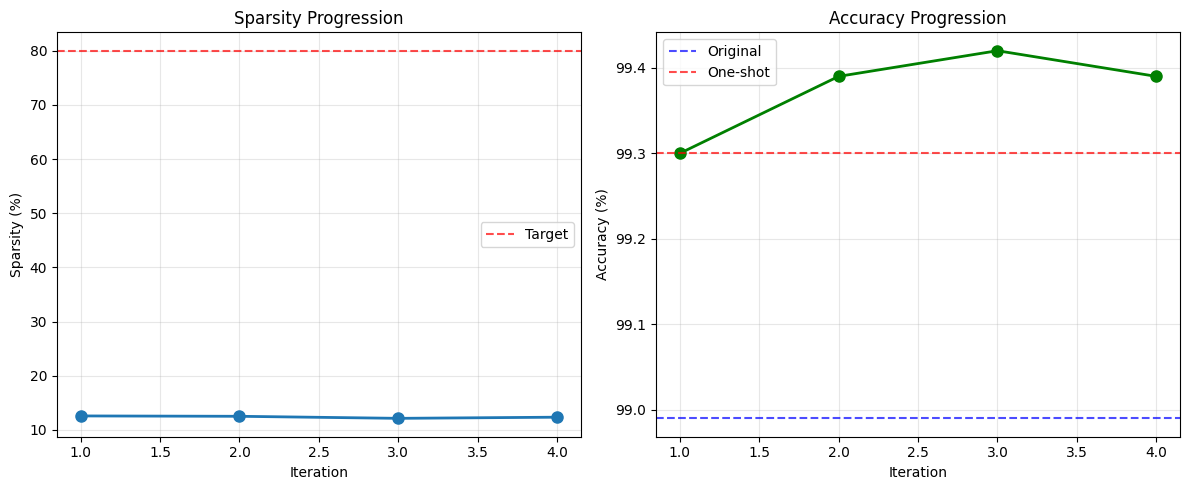

In [8]:
# Plot iterative pruning progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Sparsity progression
ax1.plot(iterative_history['iteration'], [s * 100 for s in iterative_history['sparsity']], 
         'o-', linewidth=2, markersize=8)
ax1.axhline(y=target_sparsity * 100, color='red', linestyle='--', alpha=0.7, label='Target')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Sparsity (%)')
ax1.set_title('Sparsity Progression')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Accuracy progression
ax2.plot(iterative_history['iteration'], iterative_history['accuracy'], 
         'o-', linewidth=2, markersize=8, color='green')
ax2.axhline(y=original_accuracy, color='blue', linestyle='--', alpha=0.7, label='Original')
ax2.axhline(y=oneshot_accuracy, color='red', linestyle='--', alpha=0.7, label='One-shot')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy Progression')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## 8. Sparsity Pattern Visualization {#visualization}

Visualizing sparsity patterns for conv1.weight...


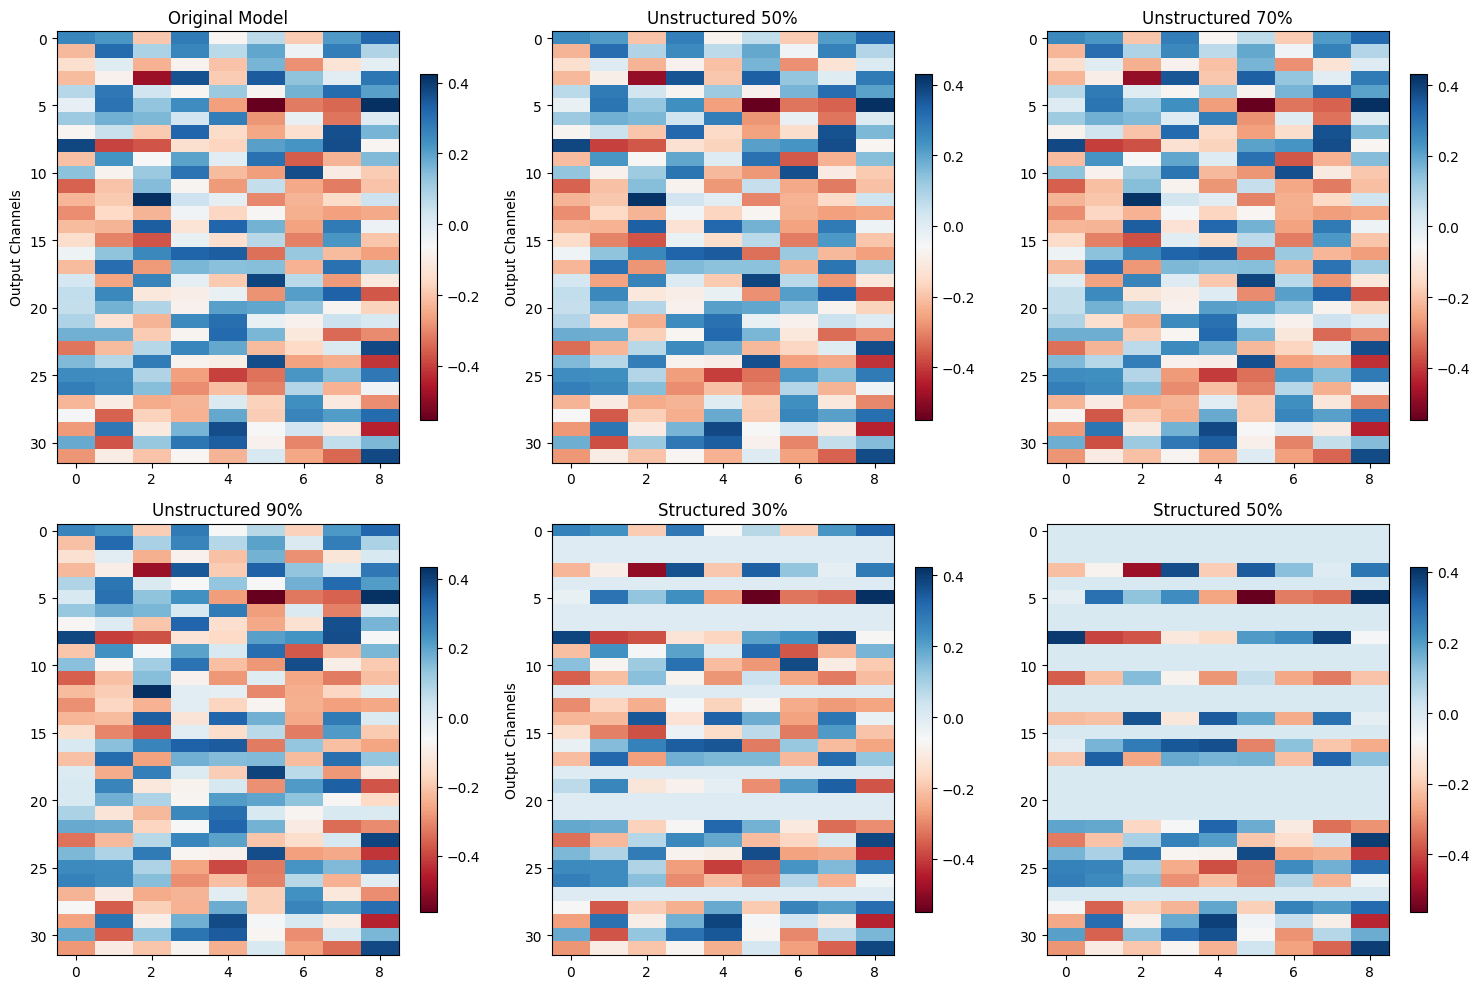

In [9]:
def visualize_sparsity_patterns(models_dict, layer_name='conv1.weight'):
    """
    Visualize sparsity patterns for different pruning methods.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Original model
    original_weights = None
    for name, param in original_model.named_parameters():
        if name == layer_name:
            original_weights = param.data.cpu().numpy()
            break
    
    if original_weights is not None:
        # Reshape to 2D for visualization
        if len(original_weights.shape) == 4:  # Conv layer
            weights_2d = original_weights.reshape(original_weights.shape[0], -1)
        else:
            weights_2d = original_weights
        
        # Original model
        im0 = axes[0].imshow(weights_2d, cmap='RdBu', aspect='auto')
        axes[0].set_title('Original Model')
        axes[0].set_ylabel('Output Channels')
        plt.colorbar(im0, ax=axes[0], shrink=0.8)
        
        # Pruned models
        plot_idx = 1
        
        # Unstructured pruning results
        for ratio, results in unstructured_results.items():
            if plot_idx >= len(axes):
                break
                
            model = results['model']
            for name, param in model.named_parameters():
                if name == layer_name:
                    pruned_weights = param.data.cpu().numpy()
                    if len(pruned_weights.shape) == 4:
                        pruned_weights_2d = pruned_weights.reshape(pruned_weights.shape[0], -1)
                    else:
                        pruned_weights_2d = pruned_weights
                    
                    im = axes[plot_idx].imshow(pruned_weights_2d, cmap='RdBu', aspect='auto')
                    axes[plot_idx].set_title(f'Unstructured {ratio:.0%}')
                    if plot_idx == 1 or plot_idx == 4:
                        axes[plot_idx].set_ylabel('Output Channels')
                    plt.colorbar(im, ax=axes[plot_idx], shrink=0.8)
                    plot_idx += 1
                    break
        
        # Structured pruning results
        for key, results in structured_results.items():
            if plot_idx >= len(axes) or 'channels' not in key:
                continue
                
            model = results['model']
            for name, param in model.named_parameters():
                if name == layer_name:
                    pruned_weights = param.data.cpu().numpy()
                    if len(pruned_weights.shape) == 4:
                        pruned_weights_2d = pruned_weights.reshape(pruned_weights.shape[0], -1)
                    else:
                        pruned_weights_2d = pruned_weights
                    
                    im = axes[plot_idx].imshow(pruned_weights_2d, cmap='RdBu', aspect='auto')
                    ratio = key.split('_')[1]
                    axes[plot_idx].set_title(f'Structured {float(ratio):.0%}')
                    if plot_idx == 1 or plot_idx == 4:
                        axes[plot_idx].set_ylabel('Output Channels')
                    plt.colorbar(im, ax=axes[plot_idx], shrink=0.8)
                    plot_idx += 1
                    break
    
    # Hide unused subplots
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Visualize sparsity patterns
print("Visualizing sparsity patterns for conv1.weight...")
visualize_sparsity_patterns({}, 'conv1.weight')

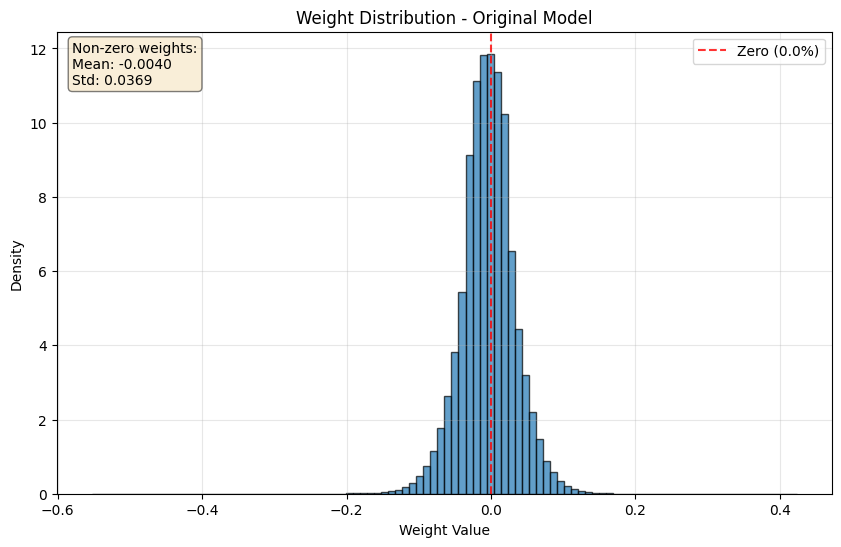

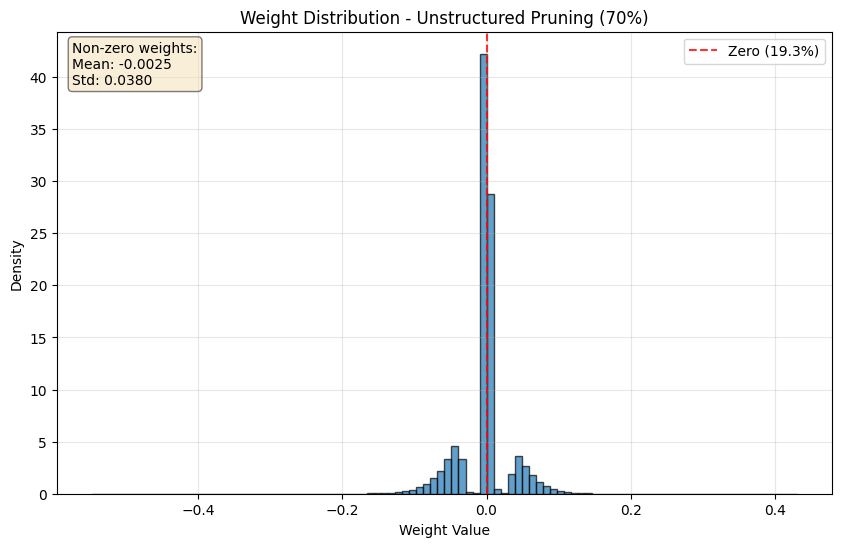

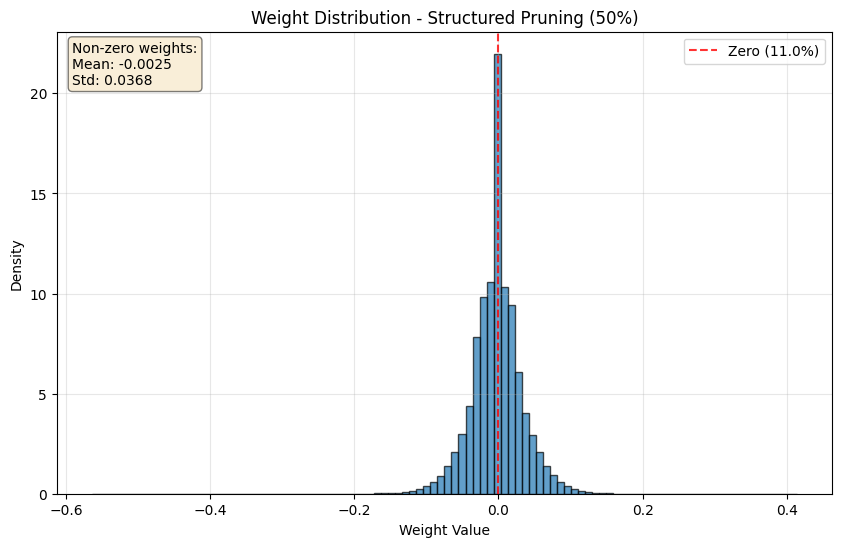

In [10]:
def plot_weight_distribution(model, title):
    """
    Plot the distribution of weights in the model.
    """
    all_weights = []
    for param in model.parameters():
        if param.dim() > 1:  # Only weight matrices/tensors
            all_weights.extend(param.data.cpu().numpy().flatten())
    
    plt.figure(figsize=(10, 6))
    plt.hist(all_weights, bins=100, alpha=0.7, density=True, edgecolor='black')
    plt.xlabel('Weight Value')
    plt.ylabel('Density')
    plt.title(f'Weight Distribution - {title}')
    plt.grid(True, alpha=0.3)
    
    # Add statistics
    weights_array = np.array(all_weights)
    zero_ratio = np.sum(weights_array == 0) / len(weights_array)
    mean_val = np.mean(weights_array[weights_array != 0])  # Mean of non-zero weights
    std_val = np.std(weights_array[weights_array != 0])   # Std of non-zero weights
    
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.8, label=f'Zero ({zero_ratio:.1%})')
    plt.legend()
    
    textstr = f'Non-zero weights:\nMean: {mean_val:.4f}\nStd: {std_val:.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.show()

# Plot weight distributions
plot_weight_distribution(original_model, 'Original Model')

if 0.7 in unstructured_results:
    plot_weight_distribution(unstructured_results[0.7]['model'], 'Unstructured Pruning (70%)')

if 'channels_0.5' in structured_results:
    plot_weight_distribution(structured_results['channels_0.5']['model'], 'Structured Pruning (50%)')

## 9. Performance Analysis {#analysis}

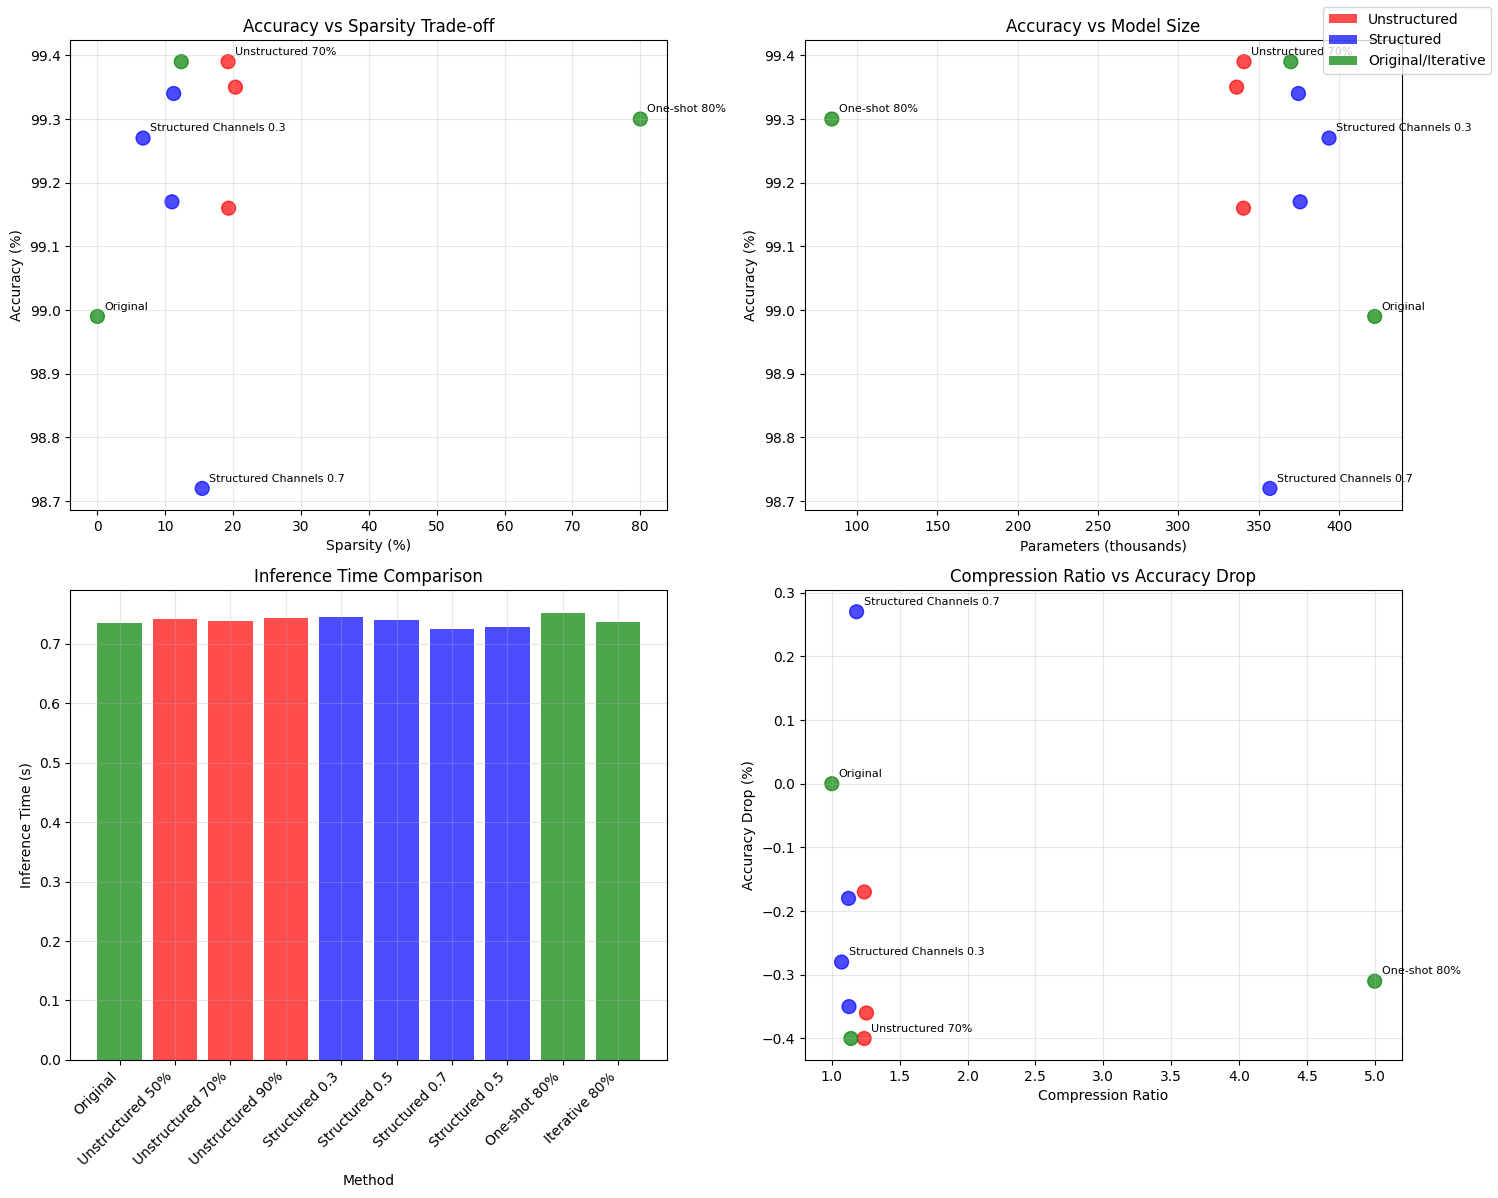

In [11]:
# Compile all results for comparison
all_results = []

# Original model
all_results.append({
    'method': 'Original',
    'sparsity': 0,
    'accuracy': original_accuracy,
    'inference_time': original_time,
    'params': original_params
})

# Unstructured results
for ratio, results in unstructured_results.items():
    all_results.append({
        'method': f'Unstructured {ratio:.0%}',
        'sparsity': results['sparsity'],
        'accuracy': results['accuracy'],
        'inference_time': results['inference_time'],
        'params': original_params * (1 - results['sparsity'])
    })

# Structured results
for key, results in structured_results.items():
    method_name = key.replace('_', ' ').title()
    all_results.append({
        'method': f'Structured {method_name}',
        'sparsity': results['sparsity'],
        'accuracy': results['accuracy'],
        'inference_time': results['inference_time'],
        'params': original_params * (1 - results['sparsity'])
    })

# Add iterative vs one-shot comparison
all_results.extend([
    {
        'method': 'One-shot 80%',
        'sparsity': target_sparsity,
        'accuracy': oneshot_accuracy,
        'inference_time': oneshot_time,
        'params': original_params * (1 - target_sparsity)
    },
    {
        'method': 'Iterative 80%',
        'sparsity': iterative_history['sparsity'][-1],
        'accuracy': iterative_accuracy,
        'inference_time': iterative_time,
        'params': original_params * (1 - iterative_history['sparsity'][-1])
    }
])

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Extract data for plotting
methods = [r['method'] for r in all_results]
sparsities = [r['sparsity'] * 100 for r in all_results]
accuracies = [r['accuracy'] for r in all_results]
times = [r['inference_time'] for r in all_results]
params = [r['params'] / 1000 for r in all_results]  # Convert to thousands

# Sparsity vs Accuracy
colors = ['red' if 'Unstructured' in m else 'blue' if 'Structured' in m else 'green' for m in methods]
ax1.scatter(sparsities, accuracies, c=colors, s=100, alpha=0.7)
for i, method in enumerate(methods):
    if i % 2 == 0:  # Annotate every other point to avoid clutter
        ax1.annotate(method, (sparsities[i], accuracies[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
ax1.set_xlabel('Sparsity (%)')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy vs Sparsity Trade-off')
ax1.grid(True, alpha=0.3)

# Model Size vs Accuracy
ax2.scatter(params, accuracies, c=colors, s=100, alpha=0.7)
for i, method in enumerate(methods):
    if i % 2 == 0:
        ax2.annotate(method, (params[i], accuracies[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
ax2.set_xlabel('Parameters (thousands)')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy vs Model Size')
ax2.grid(True, alpha=0.3)

# Inference Time Comparison
method_short = [m.split()[0] + ' ' + m.split()[-1] if len(m.split()) > 1 else m for m in methods]
bars = ax3.bar(range(len(times)), times, color=colors, alpha=0.7)
ax3.set_xlabel('Method')
ax3.set_ylabel('Inference Time (s)')
ax3.set_title('Inference Time Comparison')
ax3.set_xticks(range(len(times)))
ax3.set_xticklabels(method_short, rotation=45, ha='right')
ax3.grid(True, alpha=0.3)

# Compression Ratio vs Accuracy Drop
compression_ratios = [original_params / r['params'] if r['params'] > 0 else 1 for r in all_results]
accuracy_drops = [original_accuracy - r['accuracy'] for r in all_results]
ax4.scatter(compression_ratios, accuracy_drops, c=colors, s=100, alpha=0.7)
for i, method in enumerate(methods):
    if i % 2 == 0:
        ax4.annotate(method, (compression_ratios[i], accuracy_drops[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
ax4.set_xlabel('Compression Ratio')
ax4.set_ylabel('Accuracy Drop (%)')
ax4.set_title('Compression Ratio vs Accuracy Drop')
ax4.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', alpha=0.7, label='Unstructured'),
                  Patch(facecolor='blue', alpha=0.7, label='Structured'),
                  Patch(facecolor='green', alpha=0.7, label='Original/Iterative')]
fig.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

In [12]:
# Create a detailed comparison table
import pandas as pd

df = pd.DataFrame(all_results)
df['compression_ratio'] = original_params / df['params']
df['accuracy_drop'] = original_accuracy - df['accuracy']
df['speedup'] = original_time / df['inference_time']

# Format for display
df_display = df.copy()
df_display['sparsity'] = df_display['sparsity'].apply(lambda x: f"{x:.1%}")
df_display['accuracy'] = df_display['accuracy'].apply(lambda x: f"{x:.2f}%")
df_display['inference_time'] = df_display['inference_time'].apply(lambda x: f"{x:.4f}s")
df_display['params'] = df_display['params'].apply(lambda x: f"{x:,.0f}")
df_display['compression_ratio'] = df_display['compression_ratio'].apply(lambda x: f"{x:.2f}x")
df_display['accuracy_drop'] = df_display['accuracy_drop'].apply(lambda x: f"{x:.2f}%")
df_display['speedup'] = df_display['speedup'].apply(lambda x: f"{x:.2f}x")

print("\n=== Comprehensive Pruning Results Comparison ===")
print(df_display.to_string(index=False))

# Key insights
print("\n=== Key Insights ===")
print("1. Unstructured pruning achieves higher compression ratios but may not provide immediate speedup")
print("2. Structured pruning provides immediate speedup on standard hardware")
print("3. Iterative pruning generally preserves accuracy better than one-shot pruning")
print("4. There's a trade-off between model size reduction and accuracy preservation")

# Find best trade-offs
best_compression = df.loc[df['compression_ratio'].idxmax()]
best_accuracy = df.loc[df['accuracy'].idxmax()]
best_speedup = df.loc[df['speedup'].idxmax()]

print(f"\nBest compression ratio: {best_compression['method']} ({best_compression['compression_ratio']:.2f}x)")
print(f"Best accuracy preservation: {best_accuracy['method']} ({best_accuracy['accuracy']:.2f}%)")
print(f"Best speedup: {best_speedup['method']} ({best_speedup['speedup']:.2f}x)")


=== Comprehensive Pruning Results Comparison ===
                 method sparsity accuracy inference_time  params compression_ratio accuracy_drop speedup
               Original     0.0%   98.99%        0.7350s 422,026             1.00x         0.00%   1.00x
       Unstructured 50%    20.3%   99.35%        0.7425s 336,182             1.26x        -0.36%   0.99x
       Unstructured 70%    19.3%   99.39%        0.7383s 340,762             1.24x        -0.40%   1.00x
       Unstructured 90%    19.3%   99.16%        0.7439s 340,436             1.24x        -0.17%   0.99x
Structured Channels 0.3     6.7%   99.27%        0.7444s 393,643             1.07x        -0.28%   0.99x
Structured Channels 0.5    11.0%   99.17%        0.7396s 375,690             1.12x        -0.18%   0.99x
Structured Channels 0.7    15.4%   98.72%        0.7256s 356,861             1.18x         0.27%   1.01x
 Structured Neurons 0.5    11.2%   99.34%        0.7276s 374,598             1.13x        -0.35%   1.01x
     

## 10. Conclusions {#conclusions}

### Summary of Findings

Through our comprehensive exploration of neural network pruning techniques, we've discovered several important insights:

#### Unstructured vs Structured Pruning

**Unstructured Pruning:**
- Achieves higher compression ratios (up to 90% sparsity)
- Creates irregular sparsity patterns
- Requires specialized hardware/software for actual speedup
- Fine-grained control over which weights to remove
- Better preservation of model capacity

**Structured Pruning:**
- Provides immediate speedup on standard hardware
- Lower compression ratios but regular patterns
- Simpler implementation and deployment
- May require more careful selection of structures to remove

#### Iterative vs One-Shot Pruning

**Iterative Pruning:**
- Better accuracy preservation
- Follows the lottery ticket hypothesis
- Higher computational cost during pruning
- More stable convergence

**One-Shot Pruning:**
- Faster pruning process
- May require more aggressive fine-tuning
- Risk of removing important connections
- Suitable for less aggressive pruning ratios

### Practical Recommendations

1. **For Mobile/Edge Deployment**: Use structured pruning for immediate speedup
2. **For Maximum Compression**: Use unstructured pruning with specialized inference engines
3. **For Critical Applications**: Use iterative pruning to preserve accuracy
4. **For Quick Prototyping**: Start with magnitude-based one-shot pruning

### Trade-offs to Consider

- **Accuracy vs Efficiency**: More aggressive pruning reduces accuracy
- **Training Time vs Inference Time**: Iterative pruning takes longer but preserves performance
- **Hardware Requirements**: Unstructured pruning needs specialized support for speedup
- **Deployment Complexity**: Structured pruning is easier to deploy

### Future Directions

1. **Learned Pruning**: Using neural networks to decide what to prune
2. **Dynamic Pruning**: Adaptive pruning during inference
3. **Hardware Co-design**: Developing hardware specifically for sparse computations
4. **Combined Approaches**: Mixing structured and unstructured pruning

### Implementation Tips

1. Always establish a strong baseline before pruning
2. Monitor both accuracy and actual inference speed
3. Consider the entire deployment pipeline when choosing pruning methods
4. Experiment with different pruning schedules and criteria
5. Validate results on representative test data

This notebook demonstrates that pruning is a powerful technique for model compression, but the choice of method should be guided by specific deployment requirements and constraints.